In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## 1) Introdução
A motivação da criação deste programa é a de designação de agrupamentos onde serão alocados técnicos para manutenção em cidades ao redor de São Paulo. 
Para solucionar tal programa será usado o algoritmo K-Means para agrupar localizações de forma que a distância entre as cidades dentro de cada agrupamento seja mínima. A entrada deve ser a latitude e a longitude de  cada localização, de tal forma que o resultado do programa seja melhor quando as distâncias são pequenas e não há grandes obstaculos geográficos entre os locais. Ademais, as localizações têm pesos iguais entre si.

### Detalhes das entradas e saidas
As entradas serão da forma X[i] = (latitude, longitude) e a saída sera um vetor com a posição de cada centróide e a qual centróide cada elemento da entrada é designado.



### 2) O algoritmo
Usaremos as seguintes funções:
* find_closest_centroid(X, centroids)
    * X é o vetor das entradas, de dimensões m x n, em que m são os exemplos de treino e n são as features e centroids é o vetor com todos os centroides, com dimensões K x n, com K = número de clusters.
    * Essa função analisa para cada caso m de teste qual é o centróide mais próximo e retorna um array idx com m elementos, em que idx[i] = indexador do cluster mais próximo.
* compute_centroids(X, idx, K):
    * Essa função recebe a saída da função anterior idx e computa qual é a nova posição de cada centróide. A posição será a média das posições de cada um dos elementos mais próximos ao centróide em questão. Sua saída é um vetor com as posições de cada centróide.
* compute_cost(X, centroids, idx)
    * Essa função calcula o custo de uma configuração de agrupamento. Ela será usada para encontrar a melhor combinação de posições iniciais de cada centróide.
* run_kmeans(X, initial_centroids, max_iters, max_random_inits)
    * Essa função roda o algoritmo K-Means recursivamente o número representado por max_iters. Então, repete esse processo para encontrar a melhor configuração. Suas saídas são a posição final dos centróides (vetor centroids) e o array idx com as atribuições finais de cada elemento a um centróide.
* kMeans_init_centroids(X, K)
    * Essa função gera as posições de cada centróide a um elemento aleatório da amostra.
* find_best_Clustering(X, max_iters, max_attempts_to_find_best_K, max_random_inits)
    * Essa função roda o K-Means para todos os valores de K possíveis estabelecidos pelo usuário e armazena todos os dados obtidos para que se possa comparar a performance para cada K.

In [3]:
def find_closest_centroids(X, centroids):
    """
    Encontra o centroide mais próximo para cada exemplo no conjunto de dados.

    Argumentos:
        X (ndarray): (m, n) Input values
        centroids (ndarray): (K, n) centróides

    Retorna:
        idx (array_like): (m,) número do centróide mais próximo para cada exemplo

    """
    K = centroids.shape[0]
    idx = np.zeros(X.shape[0], dtype=int)

    for i in range(X.shape[0]):
        diff = X[i] - centroids[0]
        minDist = (np.linalg.norm(diff))**2
        for j in range(1, K):
            tempDist = (np.linalg.norm(X[i]-centroids[j]))**2
            if  tempDist < minDist:
                minDist = tempDist
                idx[i] = j

    return idx

In [4]:
def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the
    data points assigned to each centroid.

    Argumentos:
        X (ndarray):   (m, n) Data points
        idx (ndarray): (m,) Array containing index of closest centroid for each
                       example in X. Concretely, idx[i] contains the index of
                       the centroid closest to example i
        K (int):       number of centroids

    Retorna:
        centroids (ndarray): (K, n) New centroids computed
    """
    m, n = X.shape
    centroids = np.zeros((K, n))

    for i in range(K):
        counter = 0
        for j in range(m):
            if idx[j] == i:
                counter += 1
                centroids[i] = centroids[i] + X[j]
        centroids[i] = centroids[i]/counter

    return centroids

In [5]:
def compute_cost(X, centroids, idx):
    """
    Calcula o custo (distância quadrada) entre os exemplos e os centróides mais próximos.

    Argumentos:
        X (ndarray): (m, n) Input values
        centroids (ndarray): (K, n) centroid values
        idx (array_like): (m,) número do centróide mais próximo para cada exemplo

    Retorna:
        J (float): custo do agrupamento
    """
    m = X.shape[0]
    J = 0

    for i in range(m):
        J = J + (np.linalg.norm(X[i]-centroids[idx[i]]))**2

    J = J/m

    return J

In [6]:
def kMeans_init_centroids(X, K):
    """
    Essa função inicializa os centróides como K elementos aleatoriamente selecionados sem repetição para o algoritmo K-Means.

    Argumentos:
        X (ndarray): Data points
        K (int):     number of centroids/clusters

    Retorna:
        centroids (ndarray): Initialized centroids
    """

    # Reordena os índices aleatoriamente
    randidx = np.random.permutation(X.shape[0])

    # Seleciona os primeiros K exemplos como centróides
    centroids = X[randidx[:K]]

    return centroids

In [7]:
def run_kMeans(X, K, max_iters, max_random_inits):

    # Inicialização dos valores
    m, n = X.shape
    idx = np.zeros(m)
    minCentroids = []
    minIdx = []
    minCost = np.inf

    for j in range(max_random_inits):
        centroids = kMeans_init_centroids(X, K)
        for i in range(max_iters):
           # print("K-Means iteration %d/%d" % (i, max_iters-1)) # Essa linha é opcional
            idx = find_closest_centroids(X, centroids)

        centroids = compute_centroids(X, idx, K)
        tempCost = compute_cost(X, centroids, idx)
        if tempCost < minCost:
            minCost = tempCost
            minCentroids = centroids
            minIdx = idx


    return minCentroids, minIdx

In [8]:
def find_best_Clustering(X, max_iters, max_attempts_to_find_best_K, max_random_inits):
    """
    Encontra o melhor valor de K para o conjunto de dados.

    Argumentos:
        X (ndarray): (m, n) Input values
        max_iters (int): número máximo de iterações
        plot_progress (bool): se True, mostra o progresso do algoritmo

    Retorna:
        best_K (int): melhor valor de K
        best_centroids (ndarray): (K, n) centroid values
        best_idx (array_like): (m,) número do centróide mais próximo para cada exemplo
    """
    best_centroids = []
    best_idx = []
    tempCost = []
    print("Treinamento iniciado")
    for K in range(1, max_attempts_to_find_best_K+1):
       # print("Rodando K-Means para K = %d" % K) # Essa linha é opcional
        centroids, idx = run_kMeans(X, K, max_iters, max_random_inits)
        cost = compute_cost(X, centroids, idx)
        tempCost.append(cost)
        best_centroids.append(centroids)
        best_idx.append(idx)
    print("Treinamento completo")
    return tempCost, best_centroids, best_idx

In [9]:
def plotDataPoints(X, idx, K):
    """
    Plota os pontos de dados em X, coloridos de acordo com os índices idx.

    Argumentos:
        X (ndarray): (m, n) Input values
        idx (array_like): (m,) número do centróide mais próximo para cada exemplo
        K (int): número de centróides

    Retorna:
        None
    """
    colors = ['r', 'g', 'b', 'y', 'k', 'c', 'm', "pink", "grey"]
    assert K <= len(colors), 'K is too large'

    for i in range(K):
        plt.scatter(X[idx == i, 0], X[idx == i, 1], c=colors[i], s=15)

    plt.show()

In [10]:
def plotCostByK(K, cost):
    """
    Plota o custo em função do número de clusters.

    Argumentos:
        K (int): número de clusters
        cost (array_like): custo para cada valor de K

    Retorna:
        None
    """
    line, = plt.plot(range(1, K+1), cost, '-o')
    plt.xlabel('Número de regiões')
    plt.ylabel('Distância média do centróide')
    plt.title('Custo vs número de regiões')
    plt.show()

### 2.1 Aplicação
Com todo o algoritmo pronto, basta designar o vetor X das entradas, max_K, que representa o número máximo de clusters, max_iters, que representa o máximo de iterações que o K-Means deve fazer, e max_random_inits, que é o máximo de vezes que se tenta inicializar o K-Means de tal forma que se minimize o custo.

In [11]:
# Carregar o arquivo Excel
df = pd.read_excel("latitudesElongitudes.xlsx")
vetor_de_vetores = np.array(df[['Latitude', 'Longitude']])
X = vetor_de_vetores
# Definir o número máximo de clusters e outras variáveis de controle
max_K = 20
max_iters = 20
max_random_inits = 100
# Rodar o algoritmo e obter todos os resultados para cada valor de K
Cost_for_every_K, best_centroids, best_idx = find_best_Clustering(X, max_iters, max_K, max_random_inits)





Treinamento iniciado
Treinamento completo


## 3) Interpretação dos resultados
Agora que concluimos o treinamento do modelo, faz-se necessário escolher o melhor valor para K, isto é, o número de regiões que deseja-se ter de tal forma que se equilibre a distância média até o centróide com o gasto total com as subdivisões.
Para tal, podemos procurar por "cotovelos", em que a função custo passa a apresentar decrescimento reduzido.

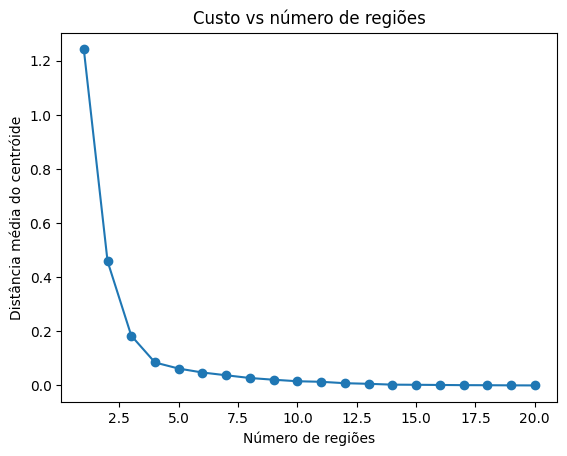

In [12]:

plotCostByK(max_K, Cost_for_every_K)

## 4) Avaliação dos resultados
Podemos agora verificar como ficou o agrupamento obtido pelo algoritmo para avaliar o modelo. Basta inserir o valor de K escolhido para obter um gráfico

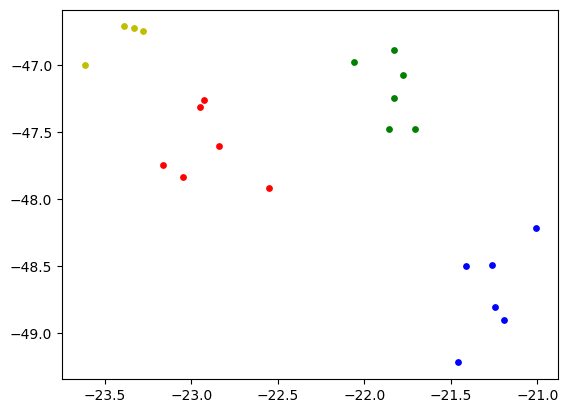

In [13]:
best_K = 4
plotDataPoints(X, best_idx[best_K-1], best_K)

## 5) Enviar os dados para o Excel
Agora enviaremos os dados como uma tabela no excel para facilitar a exportação.

In [14]:
print(best_centroids[best_K-1])
df = pd.DataFrame({
    'Melhores clusters': best_idx[best_K-1],
    'Posições dos centróides': [best_centroids[best_K-1][i] for i in best_idx[best_K-1]]
})
print(df)
df.to_excel("output.xlsx", index=False)

[[-22.91327487 -47.61226685]
 [-21.84290812 -47.1927714 ]
 [-21.26372053 -48.68875383]
 [-23.40513982 -46.79664645]]
    Melhores clusters                    Posições dos centróides
0                   2  [-21.263720533333334, -48.68875383333333]
1                   2  [-21.263720533333334, -48.68875383333333]
2                   0        [-22.913274866666665, -47.61226685]
3                   0        [-22.913274866666665, -47.61226685]
4                   2  [-21.263720533333334, -48.68875383333333]
5                   0        [-22.913274866666665, -47.61226685]
6                   0        [-22.913274866666665, -47.61226685]
7                   3              [-23.405139825, -46.79664645]
8                   3              [-23.405139825, -46.79664645]
9                   3              [-23.405139825, -46.79664645]
10                  1         [-21.842908116666663, -47.1927714]
11                  2  [-21.263720533333334, -48.68875383333333]
12                  2  [-21.2637205333

## 6) Considerações finais
Agora que o programa está concluido, basta encontrar as cidades mais próximas de cada centróide e verificar a disponibilidade de técnicos de manutenção na área.